# Movielens Recommender

- Session based recommenders system
- Movielens 1M dataset

In [438]:
import datetime as dt
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

# Data Load

In [439]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3],
                      dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
    return data

In [440]:
data_path = Path(os.getenv('HOME')+'/aiffel/aiffel_projects/exploration/E12_yoochoose/data')
train_path = data_path / 'ratings.dat'

rating_data = load_data(train_path)
rating_data.sort_values(['user_id', 'timestamp'], inplace=True)

rating_data

,user_id,movie_id,rating,timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


<br>

# Data Exploration & Preprocess

## 1) user_id, movie_id

- user_id가 session_id 역할을 한다고 가정
- user_id별 movie_id가 몇 개 정도 되는지 분포 확인
- movie_id별 user_id가 몇 개 정도 되는지 분포 확인
- 100명 미만이 본 영화는 삭제

In [441]:
# user별 시청한 영화가 몇 편인지 분포를 확인
movies_per_user = rating_data.groupby('user_id')['movie_id'].size()

In [442]:
movies_per_user.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: movie_id, dtype: float64

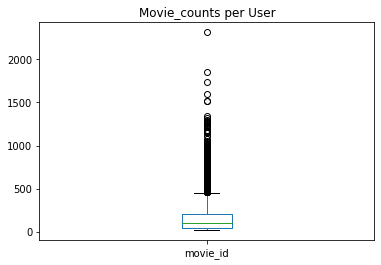

In [443]:
movies_per_user.plot(kind='box', title='Movie_counts per User')

plt.show()

In [444]:
# movie count별 user_id 개수
users_per_movie = rating_data.groupby('movie_id')['user_id'].size()

users_per_movie.describe()

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
25%        33.000000
50%       123.500000
75%       350.000000
max      3428.000000
Name: user_id, dtype: float64

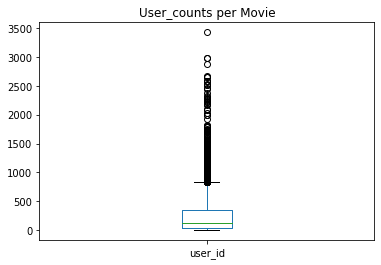

In [445]:
users_per_movie.plot(kind='box', title='User_counts per Movie')

plt.show()

In [446]:
users_per_movie = pd.DataFrame(users_per_movie)

users_per_movie

,user_id
movie_id,
1,2077
2,701
3,478
4,170
5,296
...,...
3948,862
3949,304
3950,54


In [447]:
# 100명 미만이 본 영화는 삭제
tmp_remove = users_per_movie.loc[users_per_movie['user_id'] < 100].index

tmp_remove

Int64Index([   8,   13,   27,   30,   33,   35,   37,   38,   40,   49,
            ...
            3939, 3940, 3941, 3942, 3943, 3944, 3945, 3947, 3950, 3951],
           dtype='int64', name='movie_id', length=1687)

In [448]:
data = rating_data[~rating_data['movie_id'].isin(tmp_remove)]

data.shape

(942225, 4)

## 2) Timestamp

- unix time -> datetime 변환
- datetime 분포 확인

In [449]:
data.reset_index(drop=True, inplace=True)

data

,user_id,movie_id,rating,timestamp
0,1,3186,4,978300019
1,1,1270,5,978300055
2,1,1721,4,978300055
3,1,1022,5,978300055
4,1,2340,3,978300103
...,...,...,...,...
942220,6040,2917,4,997454429
942221,6040,1921,4,997454464
942222,6040,1784,3,997454464
942223,6040,161,3,997454486


In [450]:
# unix time -> datetime 변환
datetime = data['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))

datetime

0        2000-12-31 22:00:19
1        2000-12-31 22:00:55
2        2000-12-31 22:00:55
3        2000-12-31 22:00:55
4        2000-12-31 22:01:43
                 ...        
942220   2001-08-10 14:40:29
942221   2001-08-10 14:41:04
942222   2001-08-10 14:41:04
942223   2001-08-10 14:41:26
942224   2001-08-20 13:44:15
Name: timestamp, Length: 942225, dtype: datetime64[ns]

In [451]:
tmp_df = pd.DataFrame(data=datetime.values, columns=['datetime'], index=datetime.index)

tmp_df

,datetime
0,2000-12-31 22:00:19
1,2000-12-31 22:00:55
2,2000-12-31 22:00:55
3,2000-12-31 22:00:55
4,2000-12-31 22:01:43
...,...
942220,2001-08-10 14:40:29
942221,2001-08-10 14:41:04
942222,2001-08-10 14:41:04
942223,2001-08-10 14:41:26


In [452]:
# index를 기준으로 join
data = data.join(tmp_df, how='outer')

data

,user_id,movie_id,rating,timestamp,datetime
0,1,3186,4,978300019,2000-12-31 22:00:19
1,1,1270,5,978300055,2000-12-31 22:00:55
2,1,1721,4,978300055,2000-12-31 22:00:55
3,1,1022,5,978300055,2000-12-31 22:00:55
4,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
942220,6040,2917,4,997454429,2001-08-10 14:40:29
942221,6040,1921,4,997454464,2001-08-10 14:41:04
942222,6040,1784,3,997454464,2001-08-10 14:41:04
942223,6040,161,3,997454486,2001-08-10 14:41:26


In [453]:
# 기존 timestamp column drop
data.drop('timestamp', axis=1, inplace=True)

data

,user_id,movie_id,rating,datetime
0,1,3186,4,2000-12-31 22:00:19
1,1,1270,5,2000-12-31 22:00:55
2,1,1721,4,2000-12-31 22:00:55
3,1,1022,5,2000-12-31 22:00:55
4,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
942220,6040,2917,4,2001-08-10 14:40:29
942221,6040,1921,4,2001-08-10 14:41:04
942222,6040,1784,3,2001-08-10 14:41:04
942223,6040,161,3,2001-08-10 14:41:26


## 3) Session_id 부여

- user_id별 datetime min, max 차이를 초(sec) 단위로 확인
- 1 세션 = 30min = 1800s로 가정
- user_id별 timestamp.min을 첫 번째 session_id, 이후 1800s 단위로 순서대로 session_id를 부여

In [454]:
# user_id별 time.max() - time.min()
min_time = data.groupby('user_id')['datetime'].min()
max_time = data.groupby('user_id')['datetime'].max()

user_time_diff = max_time - min_time

user_time_diff

user_id
1        6 days 01:38:52
2        0 days 00:34:10
3        0 days 00:24:46
4        0 days 00:05:58
5        0 days 01:31:53
              ...       
6036     0 days 12:44:07
6037     1 days 01:47:23
6038     0 days 02:52:57
6039     0 days 14:41:11
6040   481 days 14:38:43
Name: datetime, Length: 6040, dtype: timedelta64[ns]

In [455]:
user_time_diff.describe()

count                           6040
mean      94 days 05:18:28.326986756
std      220 days 14:13:49.681434596
min                  0 days 00:01:46
25%                  0 days 00:20:05
50%           0 days 01:07:05.500000
75%          22 days 21:13:06.500000
max               1032 days 23:03:12
Name: datetime, dtype: object

In [456]:
diff_sec = user_time_diff.apply(lambda x: pd.Timedelta.total_seconds(x))

diff_sec

user_id
1         524332.0
2           2050.0
3           1486.0
4            358.0
5           5513.0
           ...    
6036       45847.0
6037       92843.0
6038       10377.0
6039       52871.0
6040    41611123.0
Name: datetime, Length: 6040, dtype: float64

In [457]:
diff_sec.describe()

count    6.040000e+03
mean     8.140708e+06
std      1.905923e+07
min      1.060000e+02
25%      1.205000e+03
50%      4.025500e+03
75%      1.977186e+06
max      8.924779e+07
Name: datetime, dtype: float64

In [458]:
# user_id별 대략적인 session 개수를 계산해보기
session_cnt = diff_sec // 1800

session_cnt

user_id
1         291.0
2           1.0
3           0.0
4           0.0
5           3.0
         ...   
6036       25.0
6037       51.0
6038        5.0
6039       29.0
6040    23117.0
Name: datetime, Length: 6040, dtype: float64

In [459]:
session_cnt.describe()

count     6040.000000
mean      4522.130629
std      10588.450612
min          0.000000
25%          0.000000
50%          2.000000
75%       1098.000000
max      49582.000000
Name: datetime, dtype: float64

In [460]:
data

,user_id,movie_id,rating,datetime
0,1,3186,4,2000-12-31 22:00:19
1,1,1270,5,2000-12-31 22:00:55
2,1,1721,4,2000-12-31 22:00:55
3,1,1022,5,2000-12-31 22:00:55
4,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
942220,6040,2917,4,2001-08-10 14:40:29
942221,6040,1921,4,2001-08-10 14:41:04
942222,6040,1784,3,2001-08-10 14:41:04
942223,6040,161,3,2001-08-10 14:41:26


In [461]:
data = data.merge(min_time, how='outer', on='user_id')

data

,user_id,movie_id,rating,datetime_x,datetime_y
0,1,3186,4,2000-12-31 22:00:19,2000-12-31 22:00:19
1,1,1270,5,2000-12-31 22:00:55,2000-12-31 22:00:19
2,1,1721,4,2000-12-31 22:00:55,2000-12-31 22:00:19
3,1,1022,5,2000-12-31 22:00:55,2000-12-31 22:00:19
4,1,2340,3,2000-12-31 22:01:43,2000-12-31 22:00:19
...,...,...,...,...,...
942220,6040,2917,4,2001-08-10 14:40:29,2000-04-25 23:05:32
942221,6040,1921,4,2001-08-10 14:41:04,2000-04-25 23:05:32
942222,6040,1784,3,2001-08-10 14:41:04,2000-04-25 23:05:32
942223,6040,161,3,2001-08-10 14:41:26,2000-04-25 23:05:32


In [462]:
data.rename(columns={'datetime_x': 'datetime', 'datetime_y': 'min_datetime'}, inplace=True)

data

,user_id,movie_id,rating,datetime,min_datetime
0,1,3186,4,2000-12-31 22:00:19,2000-12-31 22:00:19
1,1,1270,5,2000-12-31 22:00:55,2000-12-31 22:00:19
2,1,1721,4,2000-12-31 22:00:55,2000-12-31 22:00:19
3,1,1022,5,2000-12-31 22:00:55,2000-12-31 22:00:19
4,1,2340,3,2000-12-31 22:01:43,2000-12-31 22:00:19
...,...,...,...,...,...
942220,6040,2917,4,2001-08-10 14:40:29,2000-04-25 23:05:32
942221,6040,1921,4,2001-08-10 14:41:04,2000-04-25 23:05:32
942222,6040,1784,3,2001-08-10 14:41:04,2000-04-25 23:05:32
942223,6040,161,3,2001-08-10 14:41:26,2000-04-25 23:05:32


In [463]:
data['session_number'] = data.apply(lambda x: pd.Timedelta.total_seconds(x['datetime'] - x['min_datetime'])//1800, axis=1)

data

,user_id,movie_id,rating,datetime,min_datetime,session_number
0,1,3186,4,2000-12-31 22:00:19,2000-12-31 22:00:19,0.0
1,1,1270,5,2000-12-31 22:00:55,2000-12-31 22:00:19,0.0
2,1,1721,4,2000-12-31 22:00:55,2000-12-31 22:00:19,0.0
3,1,1022,5,2000-12-31 22:00:55,2000-12-31 22:00:19,0.0
4,1,2340,3,2000-12-31 22:01:43,2000-12-31 22:00:19,0.0
...,...,...,...,...,...,...
942220,6040,2917,4,2001-08-10 14:40:29,2000-04-25 23:05:32,22639.0
942221,6040,1921,4,2001-08-10 14:41:04,2000-04-25 23:05:32,22639.0
942222,6040,1784,3,2001-08-10 14:41:04,2000-04-25 23:05:32,22639.0
942223,6040,161,3,2001-08-10 14:41:26,2000-04-25 23:05:32,22639.0


In [464]:
session_unique = data['user_id'] + data['session_number']
session_unique

0             1.0
1             1.0
2             1.0
3             1.0
4             1.0
           ...   
942220    28679.0
942221    28679.0
942222    28679.0
942223    28679.0
942224    29157.0
Length: 942225, dtype: float64

In [465]:
session_unique.nunique()

16931

In [466]:
tmp_df = pd.DataFrame(session_unique, columns=['session_unique'])

tmp_df.reset_index(inplace=True)

tmp_df

,index,session_unique
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0
...,...,...
942220,942220,28679.0
942221,942221,28679.0
942222,942222,28679.0
942223,942223,28679.0


In [467]:
tmp_df['user_id'] = data['user_id']
tmp_df['session_number'] = data['session_number']

tmp_df

,index,session_unique,user_id,session_number
0,0,1.0,1,0.0
1,1,1.0,1,0.0
2,2,1.0,1,0.0
3,3,1.0,1,0.0
4,4,1.0,1,0.0
...,...,...,...,...
942220,942220,28679.0,6040,22639.0
942221,942221,28679.0,6040,22639.0
942222,942222,28679.0,6040,22639.0
942223,942223,28679.0,6040,22639.0


In [468]:
session_df = pd.DataFrame(tmp_df['session_unique'].unique(), columns=['session_unique'])
session_df.reset_index(inplace=True)
session_df.columns = ['session_id', 'session_unique']

session_df

,session_id,session_unique
0,0,1.0
1,1,2.0
2,2,292.0
3,3,3.0
4,4,4.0
...,...,...
16926,16926,9688.0
16927,16927,9689.0
16928,16928,10553.0
16929,16929,28679.0


In [469]:
final_df = pd.merge(tmp_df, session_df, how='outer', on='session_unique')
final_df

,index,session_unique,user_id,session_number,session_id
0,0,1.0,1,0.0,0
1,1,1.0,1,0.0,0
2,2,1.0,1,0.0,0
3,3,1.0,1,0.0,0
4,4,1.0,1,0.0,0
...,...,...,...,...,...
942220,942220,28679.0,6040,22639.0,16929
942221,942221,28679.0,6040,22639.0,16929
942222,942222,28679.0,6040,22639.0,16929
942223,942223,28679.0,6040,22639.0,16929


In [470]:
final_df.drop(['index', 'session_unique'], axis=1, inplace=True)
final_df

,user_id,session_number,session_id
0,1,0.0,0
1,1,0.0,0
2,1,0.0,0
3,1,0.0,0
4,1,0.0,0
...,...,...,...
942220,6040,22639.0,16929
942221,6040,22639.0,16929
942222,6040,22639.0,16929
942223,6040,22639.0,16929


In [486]:
last = data.drop(['min_datetime'], axis=1)
last

,user_id,movie_id,rating,datetime,session_number
0,1,3186,4,2000-12-31 22:00:19,0.0
1,1,1270,5,2000-12-31 22:00:55,0.0
2,1,1721,4,2000-12-31 22:00:55,0.0
3,1,1022,5,2000-12-31 22:00:55,0.0
4,1,2340,3,2000-12-31 22:01:43,0.0
...,...,...,...,...,...
942220,6040,2917,4,2001-08-10 14:40:29,22639.0
942221,6040,1921,4,2001-08-10 14:41:04,22639.0
942222,6040,1784,3,2001-08-10 14:41:04,22639.0
942223,6040,161,3,2001-08-10 14:41:26,22639.0


In [487]:
final_data = pd.merge(final_df, last, how='inner', on=['user_id', 'session_number'])
final_data

,user_id,session_number,session_id,movie_id,rating,datetime
0,1,0.0,0,3186,4,2000-12-31 22:00:19
1,1,0.0,0,1270,5,2000-12-31 22:00:55
2,1,0.0,0,1721,4,2000-12-31 22:00:55
3,1,0.0,0,1022,5,2000-12-31 22:00:55
4,1,0.0,0,2340,3,2000-12-31 22:01:43
...,...,...,...,...,...,...
75600818,6040,22639.0,16929,2917,4,2001-08-10 14:40:29
75600819,6040,22639.0,16929,1921,4,2001-08-10 14:41:04
75600820,6040,22639.0,16929,1784,3,2001-08-10 14:41:04
75600821,6040,22639.0,16929,161,3,2001-08-10 14:41:26


In [488]:
final_data.dropna(inplace=True)
final_data

,user_id,session_number,session_id,movie_id,rating,datetime
0,1,0.0,0,3186,4,2000-12-31 22:00:19
1,1,0.0,0,1270,5,2000-12-31 22:00:55
2,1,0.0,0,1721,4,2000-12-31 22:00:55
3,1,0.0,0,1022,5,2000-12-31 22:00:55
4,1,0.0,0,2340,3,2000-12-31 22:01:43
...,...,...,...,...,...,...
75600818,6040,22639.0,16929,2917,4,2001-08-10 14:40:29
75600819,6040,22639.0,16929,1921,4,2001-08-10 14:41:04
75600820,6040,22639.0,16929,1784,3,2001-08-10 14:41:04
75600821,6040,22639.0,16929,161,3,2001-08-10 14:41:26


In [489]:
final_data.drop_duplicates(inplace=True)
final_data

,user_id,session_number,session_id,movie_id,rating,datetime
0,1,0.0,0,3186,4,2000-12-31 22:00:19
1,1,0.0,0,1270,5,2000-12-31 22:00:55
2,1,0.0,0,1721,4,2000-12-31 22:00:55
3,1,0.0,0,1022,5,2000-12-31 22:00:55
4,1,0.0,0,2340,3,2000-12-31 22:01:43
...,...,...,...,...,...,...
75600728,6040,22639.0,16929,2917,4,2001-08-10 14:40:29
75600729,6040,22639.0,16929,1921,4,2001-08-10 14:41:04
75600730,6040,22639.0,16929,1784,3,2001-08-10 14:41:04
75600731,6040,22639.0,16929,161,3,2001-08-10 14:41:26


In [490]:
final_data.drop('session_number', axis=1, inplace=True)

## 4) rating

- movie별 mean, median, min, max rating 분포 확인
- 평균 rating이 3 미만인 영화는 삭제

In [491]:
r_mean = final_data.groupby('movie_id')['rating'].mean()
r_median = final_data.groupby('movie_id')['rating'].median()
r_min = final_data.groupby('movie_id')['rating'].min()
r_max = final_data.groupby('movie_id')['rating'].max()

ratings = {'mean': r_mean,
          'median': r_median,
          'min': r_min,
          'max': r_max}

ratings = pd.DataFrame(ratings)

ratings

,mean,median,min,max
movie_id,,,,
1,4.146846,4.0,1,5
2,3.201141,3.0,1,5
3,3.016736,3.0,1,5
4,2.729412,3.0,1,5
5,3.006757,3.0,1,5
...,...,...,...,...
3937,2.940741,3.0,1,5
3946,2.260000,2.0,1,5
3948,3.635731,4.0,1,5


In [492]:
ratings.loc[ratings['mean'] < 3]

,mean,median,min,max
movie_id,,,,
4,2.729412,3.0,1,5
9,2.656863,3.0,1,5
12,2.362500,2.0,1,5
15,2.458904,3.0,1,5
19,2.480720,2.0,1,5
...,...,...,...,...
3901,2.650943,3.0,1,5
3918,2.802395,3.0,1,5
3923,2.576923,3.0,1,5


In [493]:
tmp_remove = ratings.loc[ratings['mean'] < 3].index

tmp_remove

Int64Index([   4,    9,   12,   15,   19,   20,   23,   42,   44,   48,
            ...
            3841, 3864, 3877, 3879, 3889, 3901, 3918, 3923, 3937, 3946],
           dtype='int64', name='movie_id', length=488)

In [494]:
# 평점 3 미만인 영화 삭제
final_data = final_data[~final_data['movie_id'].isin(tmp_remove)]

final_data.groupby('movie_id')['rating'].mean()

movie_id
1       4.146846
2       3.201141
3       3.016736
5       3.006757
6       3.878723
          ...   
3932    3.750000
3936    3.723214
3948    3.635731
3949    4.115132
3952    3.780928
Name: rating, Length: 1531, dtype: float64

In [495]:
final_data.shape

(820721, 5)

In [496]:
final_data.tail(10)

,user_id,session_id,movie_id,rating,datetime
75600723,6040,16929,953,5,2001-08-10 14:36:00
75600724,6040,16929,1673,4,2001-08-10 14:36:52
75600725,6040,16929,457,4,2001-08-10 14:39:09
75600726,6040,16929,3671,4,2001-08-10 14:39:27
75600727,6040,16929,232,5,2001-08-10 14:39:58
75600728,6040,16929,2917,4,2001-08-10 14:40:29
75600729,6040,16929,1921,4,2001-08-10 14:41:04
75600730,6040,16929,1784,3,2001-08-10 14:41:04
75600731,6040,16929,161,3,2001-08-10 14:41:26
75600822,6040,16930,1221,4,2001-08-20 13:44:15


In [497]:
final_data.reset_index(drop=True, inplace=True)

final_data.tail(10)

,user_id,session_id,movie_id,rating,datetime
820711,6040,16929,953,5,2001-08-10 14:36:00
820712,6040,16929,1673,4,2001-08-10 14:36:52
820713,6040,16929,457,4,2001-08-10 14:39:09
820714,6040,16929,3671,4,2001-08-10 14:39:27
820715,6040,16929,232,5,2001-08-10 14:39:58
820716,6040,16929,2917,4,2001-08-10 14:40:29
820717,6040,16929,1921,4,2001-08-10 14:41:04
820718,6040,16929,1784,3,2001-08-10 14:41:04
820719,6040,16929,161,3,2001-08-10 14:41:26
820720,6040,16930,1221,4,2001-08-20 13:44:15


In [528]:
final_data[80000:80050]

,user_id,session_id,movie_id,rating,datetime
175795,648,2596,2770,4,2002-08-24 23:03:10
175794,648,2596,2710,3,2002-08-24 23:03:10
175793,648,2596,2694,4,2002-08-24 23:03:10
175792,648,2596,3298,4,2002-08-24 23:03:10
175796,648,2596,2355,4,2002-08-24 23:03:24
175798,648,2596,223,3,2002-08-24 23:03:57
175797,648,2596,3203,3,2002-08-24 23:03:57
175799,648,2596,2541,2,2002-08-24 23:03:57
175800,648,2596,2881,4,2002-08-24 23:04:26
175803,648,2596,1093,4,2002-08-24 23:04:26


## 4) Missing value

- 없으니까 넘어감

In [498]:
final_data.isna().sum()

user_id       0
session_id    0
movie_id      0
rating        0
datetime      0
dtype: int64

<hr>

<br>

# Dataset Split

- 전체 2000년 4월 25일부터 2003년 2월 28일까지의 데이터셋
- 그 중 가장 마지막 100일 동안의 데이터를 test dataset,
- 그 이전 100일 동안의 데이터를 validation dataset,
- 나머지를 train dataset으로 사용

In [500]:
final_data['datetime'].min()

Timestamp('2000-04-25 23:05:32')

In [499]:
final_data['datetime'].max()

Timestamp('2003-02-28 17:49:08')

In [535]:
def split_by_date(input_data: pd.DataFrame, n_days: int):
    # data의 가장 마지막 timestamp
    final_time = input_data['datetime'].max()
    
    # final_time보다 n_days 이전 날짜까지를 train set으로 지정
    before_date = input_data[input_data['datetime'] < final_time - dt.timedelta(days=n_days)]
    
    # final_time에서 n_days 이후부터 test set으로 지정
    after_date = input_data[input_data['datetime'] >= final_time - dt.timedelta(days=n_days)]
    
    return before_date, after_date

In [536]:
tr, test = split_by_date(final_data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [537]:
# data에 대한 정보를 살펴봅니다.
def stats_info(input_data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(input_data)}\n'
          f'\t Sessions: {input_data["session_id"].nunique()}\n'
          f'\t Items: {input_data["movie_id"].nunique()}\n'
          f'\t First Time : {input_data["datetime"].min()}\n'
          f'\t Last Time : {input_data["datetime"].max()}\n')

In [538]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 812435
	 Sessions: 15020
	 Items: 1531
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-08-12 13:53:29

* valid Set Stats Info
	 Events: 4169
	 Sessions: 760
	 Items: 1276
	 First Time : 2002-08-13 00:40:06
	 Last Time : 2002-11-20 16:38:40

* test Set Stats Info
	 Events: 4117
	 Sessions: 782
	 Items: 1271
	 First Time : 2002-11-20 20:30:02
	 Last Time : 2003-02-28 17:49:08



In [539]:
# train set에 없는 영화가 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {movie_id : index for index, movie_id in enumerate(tr['movie_id'].unique())}

def indexing(df, id2idx):
    df['movie_idx'] = df['movie_id'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [540]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [541]:
test

,user_id,session_id,movie_id,rating,datetime,movie_idx
9778,36,97,1701,4,2002-12-22 08:05:50,433
9779,36,98,2694,3,2002-12-22 08:08:14,727
9780,36,98,3786,4,2002-12-22 08:08:41,207
9781,36,98,3174,4,2002-12-22 08:11:25,566
9782,36,98,296,5,2002-12-22 08:16:59,242
...,...,...,...,...,...,...
817617,5950,16773,3948,4,2003-02-27 18:13:57,450
817618,5950,16773,3578,4,2003-02-27 18:14:30,92
817619,5950,16773,3793,3,2003-02-27 18:15:10,235
817620,5950,16774,3555,2,2003-02-27 18:15:37,1237


# Data Pipeline

In [542]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['session_id'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['session_id'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('session_id').size().cumsum()
        return offsets

In [543]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,user_id,session_id,movie_id,rating,datetime,movie_idx
0,1,0,3186,4,2000-12-31 22:00:19,0
2,1,0,1721,4,2000-12-31 22:00:55,1
3,1,0,1022,5,2000-12-31 22:00:55,2
1,1,0,1270,5,2000-12-31 22:00:55,3
4,1,0,2340,3,2000-12-31 22:01:43,4
5,1,0,1836,5,2000-12-31 22:02:52,5
6,1,0,3408,4,2000-12-31 22:04:35,6
8,1,0,1207,4,2000-12-31 22:11:59,7
7,1,0,2804,5,2000-12-31 22:11:59,8
10,1,0,720,3,2000-12-31 22:12:40,9


In [544]:
tr_dataset.click_offsets

array([     0,     24,    138, ..., 812424, 812434, 812435], dtype=int32)

In [545]:
tr_dataset.session_idx

array([    0,     1,     2, ..., 15017, 15018, 15019])

## Session Data Loader

In [546]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['movie_idx'].values[start + i]
                target = self.dataset.df['movie_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [547]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,user_id,session_id,movie_id,rating,datetime,movie_idx
0,1,0,3186,4,2000-12-31 22:00:19,0
2,1,0,1721,4,2000-12-31 22:00:55,1
3,1,0,1022,5,2000-12-31 22:00:55,2
1,1,0,1270,5,2000-12-31 22:00:55,3
4,1,0,2340,3,2000-12-31 22:01:43,4
5,1,0,1836,5,2000-12-31 22:02:52,5
6,1,0,3408,4,2000-12-31 22:04:35,6
8,1,0,1207,4,2000-12-31 22:11:59,7
7,1,0,2804,5,2000-12-31 22:11:59,8
10,1,0,720,3,2000-12-31 22:12:40,9


In [548]:
iter_ex = iter(tr_data_loader)

In [573]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 14  38 145  51]
Label Item Idx are :       [ 15  39 146 192]
Previous Masked Input Idx are []


## Modeling


In [558]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture


In [559]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [566]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['movie_id'].nunique()
        self.num_sessions = tr['session_id'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [567]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 1531)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    237450    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 1531)               78081     
Total params: 315,531
Trainable params: 315,531
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [562]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['session_id'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['session_id'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [574]:
train_model(model, args)

Train:   0%|          | 0/6229 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.78]

	 - Recall@20 epoch 1: 0.091146
	 - MRR@20    epoch 1: 0.022569



Train:   0%|          | 0/6229 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.66] 

	 - Recall@20 epoch 2: 0.102214
	 - MRR@20    epoch 2: 0.025613



Train:   0%|          | 0/6229 [00:00<?, ?it/s, accuracy=0.0234, train_loss=5.72] 

	 - Recall@20 epoch 3: 0.104167
	 - MRR@20    epoch 3: 0.027375



Train:   0%|          | 0/6229 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.52] 

	 - Recall@20 epoch 4: 0.100911
	 - MRR@20    epoch 4: 0.027959



Train:   0%|          | 0/6229 [00:00<?, ?it/s, accuracy=0.0234, train_loss=5.57] 

	 - Recall@20 epoch 5: 0.103516
	 - MRR@20    epoch 5: 0.029135



Train:   0%|          | 0/6229 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.72]

	 - Recall@20 epoch 6: 0.108073
	 - MRR@20    epoch 6: 0.028235



Train:   0%|          | 0/6229 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.46] 

	 - Recall@20 epoch 7: 0.108073
	 - MRR@20    epoch 7: 0.027922



Train:   0%|          | 0/6229 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.45]

	 - Recall@20 epoch 8: 0.112630
	 - MRR@20    epoch 8: 0.029463



Train:   0%|          | 0/6229 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.54]

	 - Recall@20 epoch 9: 0.108724
	 - MRR@20    epoch 9: 0.029591



Evaluation:  46%|████▌     | 12/26 [00:09<00:10,  1.29it/s]

	 - Recall@20 epoch 10: 0.110026
	 - MRR@20    epoch 10: 0.029413



# Test

In [575]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  46%|████▌     | 12/26 [00:08<00:10,  1.34it/s]

	 - Recall@20: 0.162109
	 - MRR@20: 0.047548



<hr>

<br>

# Conclusion

- timestamp 단위가 unix time인 걸 모르고 계속 UTC로 계산하다가 나중에서야 알았다.
- session을 제대로 계산해보려다가 시간을 매우 많이 썼다.ㅠㅠ 거의 전처리하는 시간의 대부분이 여기에 쓰였다.
- 그럼에도 불구하고 잘못 되었을 가능성이 매우 큰 것 같다.
- 그래도 결과는 아주 잘 나온 것 같다!
- 세션의 개념과 세션 기반 추천시스템에 대해 더 이해가 필요하다!
- 추천시스템은 참 재미 있는데 참 어렵다.